In [1]:
# =====================================
# Step 5: Semantic Search Recommender
# =====================================

# 1. Install and import dependencies
!pip install sentence-transformers pandas

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt


/opt/anaconda3/envs/acad/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Recommendation using Knowledge Base 2


In [3]:
# from google.colab import files
import pandas as pd

# Prompt to upload files (you can select multiple)
# uploaded = files.upload()

# After uploading, you can read them like this:
kb = pd.read_csv("recommendation_knowledge_base.csv")  # update filename if different
topic_labels = pd.read_excel("reddit_topics_labeled.xlsx")

✅ Knowledge base loaded: 38 rows
Columns in topic label file: ['id', 'title', 'selftext', 'score', 'num_comments', 'url', 'created_utc', 'subreddit', 'has_image', 'embedding_text', 'embedding_image', 'embedding_combined', 'topic', 'prob_topic_0', 'prob_topic_1', 'prob_topic_2', 'prob_topic_3', 'prob_topic_4', 'prob_topic_5', 'prob_topic_6', 'prob_topic_7', 'prob_topic_8', 'prob_topic_9', 'label']


Batches: 100%|██████████| 1/1 [00:00<00:00, 98.57it/s]



💬 USER QUERY: I need an AI that can patiently explain coding errors and guide me step-by-step through debugging
🔍 Matched Topic → Use Case: Coding & Development  (ID: Use Case: Coding & Development,  Similarity: 0.33)

📊  Top LLM recommendations for **Use Case: Coding & Development**:

  1. DeepSeek — 100.0% positive
  2. Claude — 48.9% positive
  3. ChatGPT — 42.9% positive
  4. Gemini — 42.9% positive


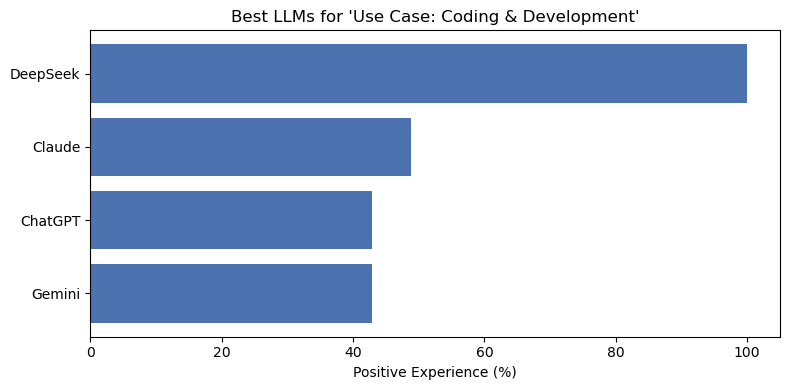


💬 USER QUERY: I'm looking for the best AI for creating images and videos, which LLM gives the most creative results?
🔍 Matched Topic → Use Case: Image & Video Generation (Creative)  (ID: Use Case: Image & Video Generation (Creative),  Similarity: 0.56)

📊  Top LLM recommendations for **Use Case: Image & Video Generation (Creative)**:

  1. Grok — 80.0% positive
  2. Gemini — 75.0% positive
  3. ChatGPT — 66.7% positive


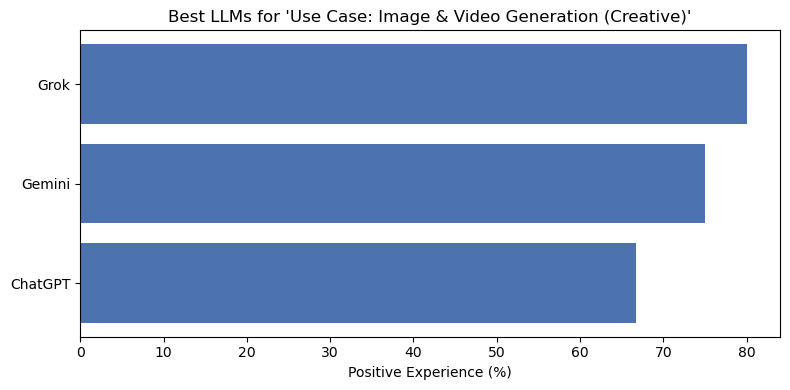

👋 Exiting Recommender. Goodbye!


In [5]:
# -----------------------------------------------------
# 1️ Load Knowledge Base (Updated for New CSV)
# -----------------------------------------------------
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

kb = pd.read_csv("recommendation_knowledge_base.csv")
kb['llm_parent'] = kb['llm_parent'].fillna("Unknown").astype(str)
kb['topic_label'] = kb['topic_label'].astype(str)
print(f"✅ Knowledge base loaded: {kb.shape[0]} rows")

# -----------------------------------------------------
# 2️ Load topic labels (BERTopic output) — keep this part intact
# -----------------------------------------------------
topic_labels = pd.read_excel("reddit_topics_labeled.xlsx")
print("Columns in topic label file:", topic_labels.columns.tolist())

# Automatically detect best column pair
topic_col = [c for c in topic_labels.columns if 'topic' in c.lower()][0]
name_col_candidates = [c for c in topic_labels.columns if any(k in c.lower() for k in ['name','represent','label','desc'])]
name_col = name_col_candidates[0] if name_col_candidates else topic_col

topic_map = topic_labels[[topic_col, name_col]].dropna().copy()
topic_map.columns = ['Topic', 'Name']
topic_map['Topic'] = topic_map['Topic'].astype(str)
topic_dict = dict(zip(topic_map['Topic'], topic_map['Name']))

# Map topic names to knowledge base
kb['topic_name'] = kb['topic_label'].map(topic_dict).fillna(kb['topic_label'])

# -----------------------------------------------------
# 3️ Load the same model used in BERTopic
# -----------------------------------------------------
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create topic embeddings (based on the topic labels in KB)
topics = kb['topic_label'].unique().tolist()
topic_embeddings = model.encode(topics, convert_to_tensor=True, show_progress_bar=True)

# -----------------------------------------------------
# 4️ Define recommender (using new columns)
# -----------------------------------------------------
def recommend_llm(user_query, kb, model, topics, topic_embeddings):
    llm_col = 'llm_parent'  # updated
    score_col = 'positive_experience_score'  # updated

    # Encode query
    query_emb = model.encode(user_query, convert_to_tensor=True)
    sims = util.cos_sim(query_emb, topic_embeddings)[0]

    # Get best topic match
    best_idx = sims.argmax().item()
    best_topic = topics[best_idx]
    best_score = sims[best_idx].item()

    topic_name = kb[kb['topic_label'] == best_topic]['topic_name'].iloc[0]

    print("\n" + "="*70)
    print(f"💬 USER QUERY: {user_query}")
    print(f"🔍 Matched Topic → {topic_name}  (ID: {best_topic},  Similarity: {best_score:.2f})")

    # Filter and sort
    subset = kb[kb['topic_label'] == best_topic].copy()
    subset = subset.sort_values(score_col, ascending=False)
    subset[llm_col] = subset[llm_col].fillna("Unknown").astype(str)

    if subset.empty:
        print("⚠️  No LLM data found for this topic.")
        return

    print(f"\n📊  Top LLM recommendations for **{topic_name}**:\n")
    for rank, (_, row) in enumerate(subset.iterrows(), start=1):
        print(f"  {rank}. {row[llm_col]} — {row[score_col]:.1f}% positive")

    # Visualization
    plt.figure(figsize=(8,4))
    plt.barh(subset[llm_col], subset[score_col], color="#4C72B0")
    plt.xlabel('Positive Experience (%)')
    plt.title(f"Best LLMs for '{topic_name}'")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 5️ Interactive Loop
# -----------------------------------------------------
while True:
    user_input = input("\n💡 Enter your use case (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("👋 Exiting Recommender. Goodbye!")
        break
    recommend_llm(user_input, kb, model, topics, topic_embeddings)
